In [1]:
import rioxarray as rx
import xarray as xr
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import joblib
import contextily as cx
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.family'] = ['Times New Roman + SimSun + Nowar Sans GB18030', ]  # set font: simhei, Heiti TC
font_name = "Times New Roman + SimSun + Nowar Sans GB18030"

In [2]:
import geopandas as gpd
from rasterstats import zonal_stats
import rasterio
from scipy.stats import pearsonr

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import kruskal
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

In [4]:
import os
os.chdir(r"/Volumes/2TMyRes/SynologyDrive/SCI/BeijingHeatExposure")

In [5]:
data_a = gpd.read_file('./EXPOSURE/final_many_idx.geojson')

In [6]:
data_a.head(1)

,net_id,Id,总人口,0-14,15-59,60以上,65以上,均价,建筑年代2,HSV,HSI,SHSR,MCHSD,CEHL,label,geometry
0,33,5ring,837.051829,100.615946,544.191633,190.950479,132.33866,31686.0,1994.0,0.476777,33.53758,0.979802,26.788571,44.139093,S,"POLYGON ((116.3724 39.76337, 116.37532 39.7633..."


In [7]:
dic = {
    '2ring': 'The 2nd ring',
    '3ring': 'The 3rd ring',
    '4ring': 'The 4th ring',
    '5ring': 'The 5th ring'
}

data_a['Id'] = data_a['Id'].map(dic)

# 区域间的差异（使用 Kruskal-Wallis 和 Dunn's test）

In [8]:
def KandD(data=data_a,label='HSV'):
    data = data[['Id',label]]
    data_2ring = data[data['Id'] == 'The 2nd ring']['Id'].values
    data_3ring = data[data['Id'] == 'The 3rd ring']['Id'].values
    data_4ring = data[data['Id'] == 'The 4th ring']['Id'].values
    data_5ring = data[data['Id'] == 'The 5th ring']['Id'].values
    print(len(data_2ring), len(data_3ring), len(data_4ring), len(data_5ring))
    # ======================================
    # 2. Kruskal–Wallis H 检验
    # ======================================
    H, p = kruskal(data_2ring, data_3ring, data_4ring, data_5ring)
    print("Kruskal–Wallis H test:")
    print(f"H statistic = {H:.4f}, p-value = {p:.6f}")
    
    # ======================================
    # 3. Dunn’s test（Holm 校正）
    # ======================================
    dunn = sp.posthoc_dunn(data, val_col=label, group_col="Id", p_adjust="holm").round(3)
    print("\nDunn’s post hoc test (Holm corrected):")

    pc = sp.posthoc_conover(data, val_col=label, group_col="Id", p_adjust="holm")
    cmap = ['1', '#fb6a4a',  '#08306b',  '#4292c6', '#c6dbef']
    heatmap_args = {'cmap': cmap, 'linewidths': 0.5, 'linecolor': '0.5', 'clip_on': False, 'square': True, 'cbar_ax_bbox': [0.83, 0.35, 0.04, 0.3]}
    ax = sp.sign_plot(pc, **heatmap_args)
    ax[0].tick_params(which='both', labelsize=13)
    cbar_ax = ax[1] 
    # 调整颜色条刻度标签的大小
    cbar_ax.ax.tick_params(labelsize=13) # 将大小设置为13，您可以根据需要更改
    plt.savefig(f'./SavedFig3/dunn-{label}.png', dpi=300)
    return ax

In [9]:
data_a.columns

Index(['net_id', 'Id', '总人口', '0-14', '15-59', '60以上', '65以上', '均价', '建筑年代2',
       'HSV', 'HSI', 'SHSR', 'MCHSD', 'CEHL', 'label', 'geometry'],
      dtype='object')

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kruskal, mannwhitneyu
import scikit_posthocs as sp

# --- 1. 辅助函数：计算 CLES 矩阵 ---
def get_cles_matrix(df, val_col, group_col):
    groups = df[group_col].unique()
    # 确保矩阵顺序与 scikit-posthocs 的输出顺序一致（通常是字母排序）
    groups = np.sort(groups) 
    
    matrix = pd.DataFrame(index=groups, columns=groups, dtype=float)
    
    for r in groups:
        for c in groups:
            if r == c:
                matrix.loc[r, c] = 0.5
                continue
            
            data_r = df[df[group_col] == r][val_col]
            data_c = df[df[group_col] == c][val_col]
            
            # 计算 r > c 的概率
            stat, _ = mannwhitneyu(data_r, data_c, alternative='two-sided')
            n1 = len(data_r)
            n2 = len(data_c)
            # 注意：Mannwhitneyu 返回的 stat 对应第一个参数 (data_r)
            cles = stat / (n1 * n2)
            matrix.loc[r, c] = cles
            
    return matrix

In [11]:
# 1. 定义转换函数
def get_significance_label(coef, p):
    if p < 0.001:
        return f"{coef:.3f}***"
    elif p < 0.01:
        return f"{coef:.3f}*"
    elif p < 0.05:
        return f"{coef:.3f}*"
    else:
        return f"{coef:.3f}"

Groups: ['The 2nd ring' 'The 3rd ring' 'The 4th ring' 'The 5th ring']
Sample sizes: [16979, 21313, 24529, 22754]

Kruskal–Wallis H test:
H statistic = 12242.8396, p-value = 0.000000
[['' '0.731***' '0.794***' '0.759***']
 ['0.269***' '' '0.591***' '0.561***']
 ['0.206***' '0.409***' '' '0.478***']
 ['0.241***' '0.439***' '0.522***' '']]


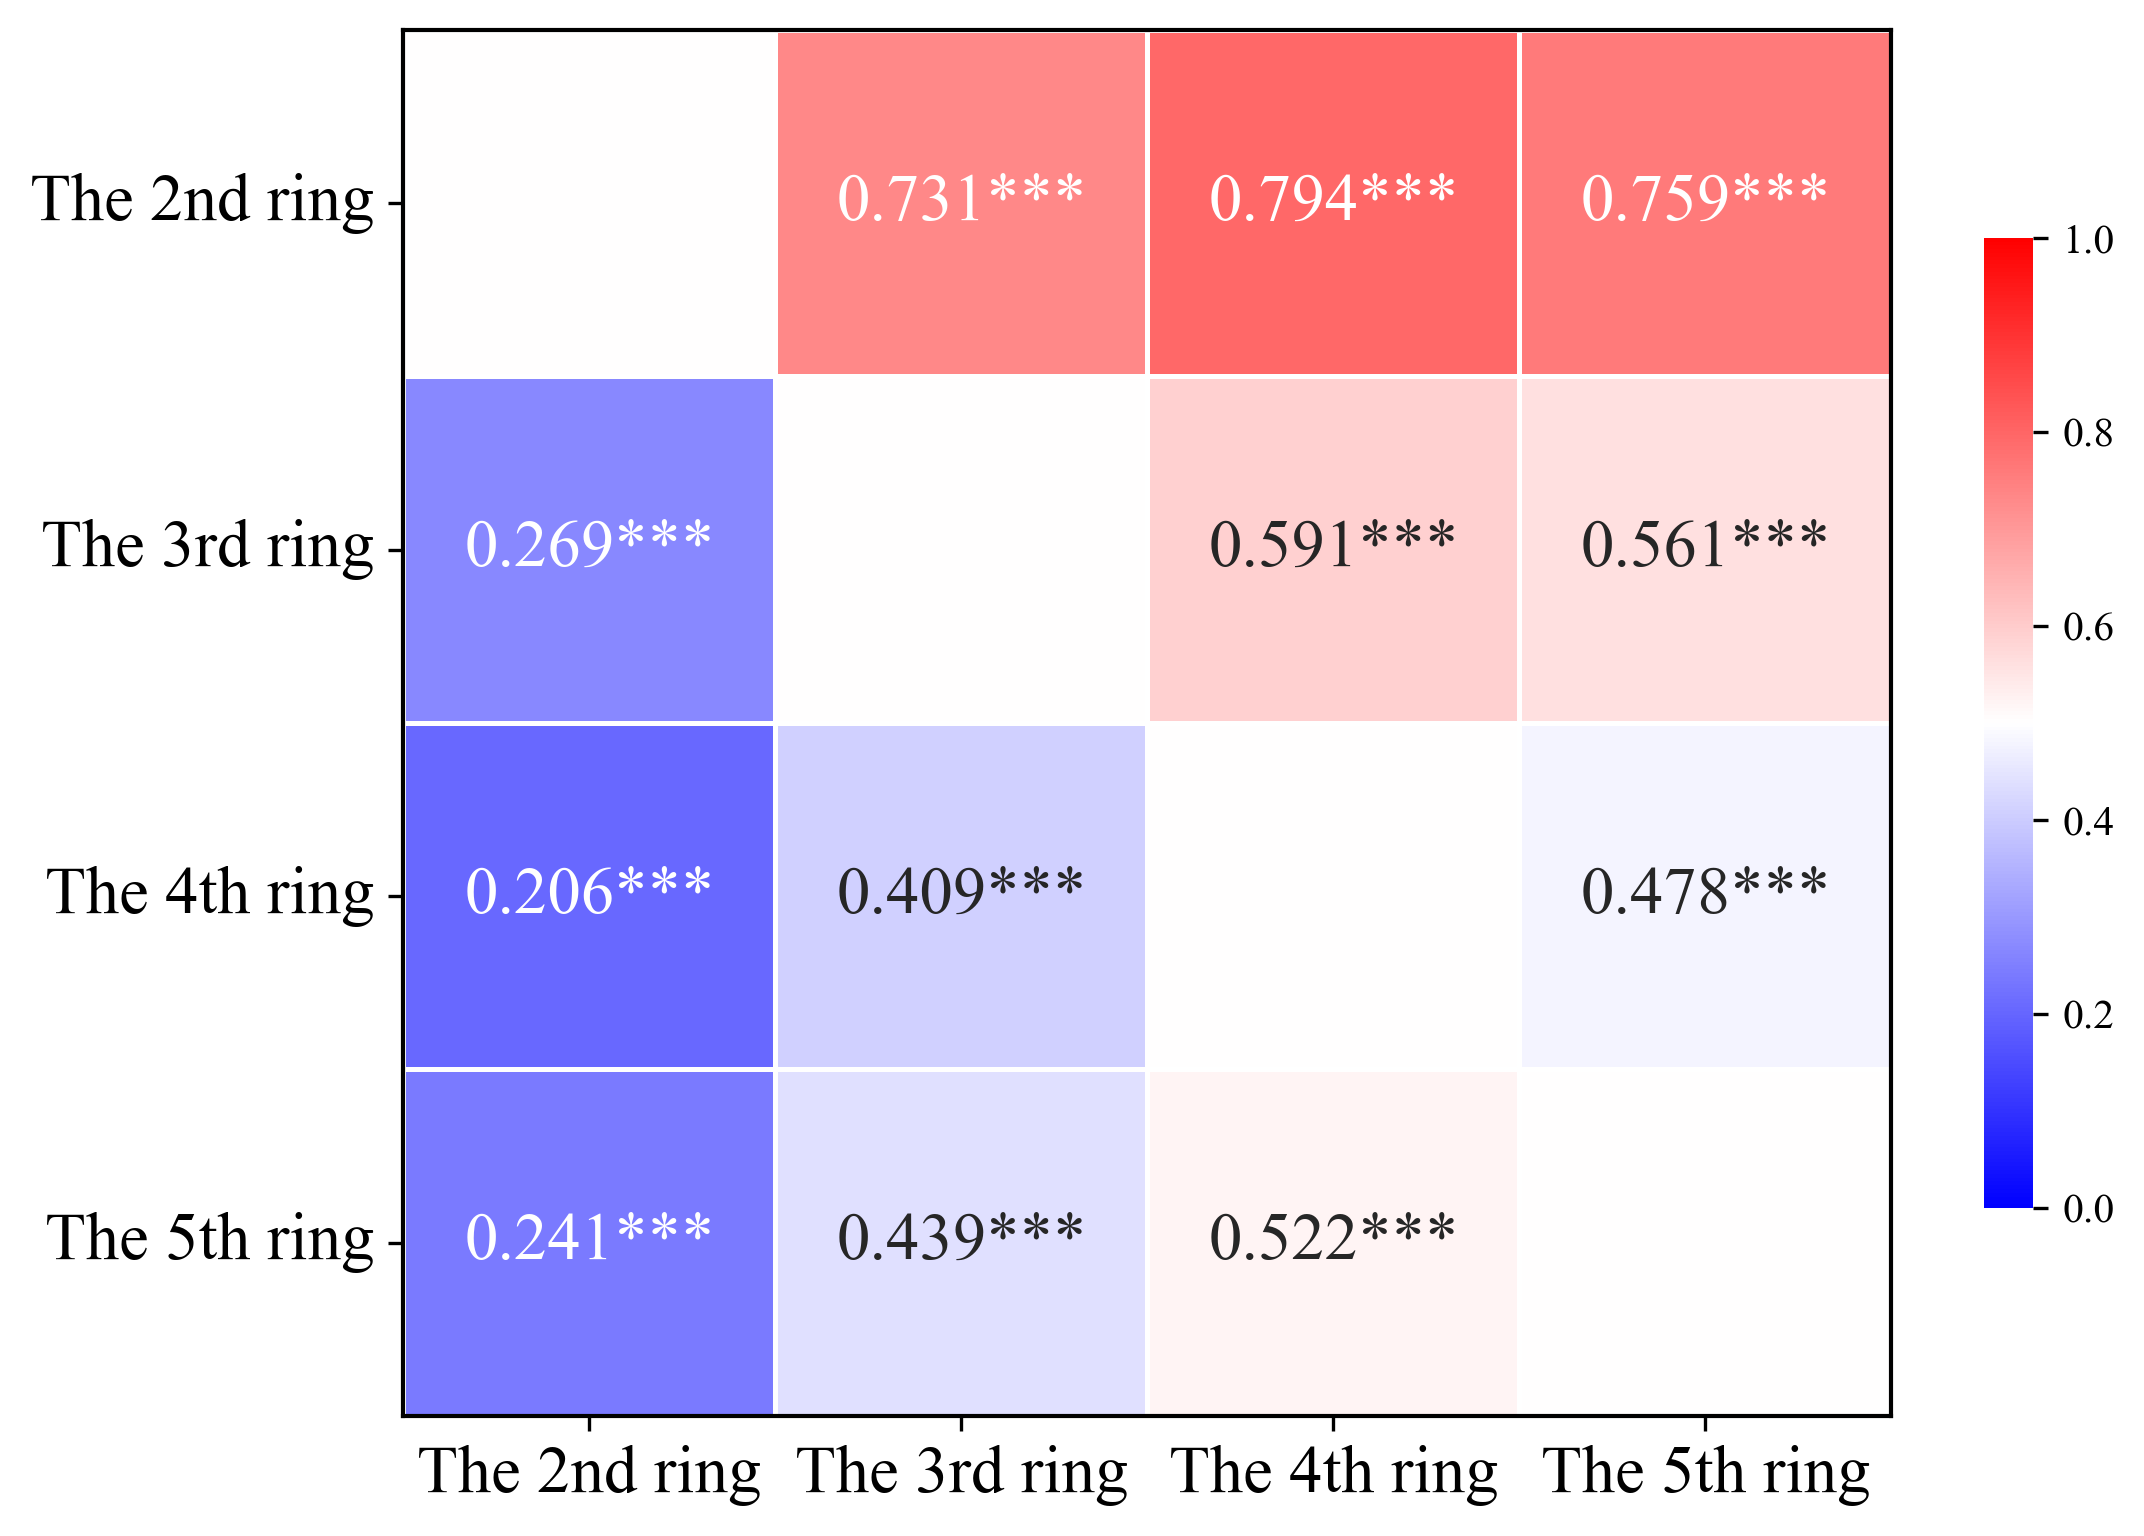

In [12]:
# --- 2. 主函数 ---
def KandD(data=None, label='HSV'): # 注意：data不能默认为data_a，除非它是全局变量
    # 筛选需要的列
    data = data[['Id', label]].copy() # 使用 copy 防止 SettingWithCopyWarning
    
    # -----------------------------------------------------------
    # [修复错误]：你之前提取的是 ['Id'].values (字符串)，这里必须提取 [label].values (数值)
    # -----------------------------------------------------------
    groups_data = []
    # 自动获取所有分组，不需要手动写 2nd, 3rd, 4th...
    # 按照 Id 排序以匹配后续矩阵顺序
    group_names = np.sort(data['Id'].unique())
    
    for g_name in group_names:
        groups_data.append(data[data['Id'] == g_name][label].values)
    
    # 打印样本量
    print(f"Groups: {group_names}")
    print("Sample sizes:", [len(g) for g in groups_data])

    # ======================================
    # 2. Kruskal–Wallis H 检验
    # ======================================
    H, p = kruskal(*groups_data) # 使用 * 解包列表
    print("\nKruskal–Wallis H test:")
    print(f"H statistic = {H:.4f}, p-value = {p:.6f}")
    
    # ======================================
    # 3. Dunn’s test（Holm 校正）
    # ======================================
    # 注意：sign_plot 需要的是 P 值矩阵
    dunn = sp.posthoc_dunn(data, val_col=label, group_col="Id", p_adjust="holm")
    
    # ======================================
    # 4. 计算 CLES 矩阵 (用于标注)
    # ======================================
    cles_matrix = get_cles_matrix(data, val_col=label, group_col="Id")

    # ======================================
    # 5. 绘图
    # ======================================

    annot_labels = []
    rows, cols = dunn.shape
    for i in range(rows):
        row_labels = []
        for j in range(cols):
            if i == j:
                row_labels.append("")  # 对角线位置设为空字符串
            else:
                coef = cles_matrix.iloc[i, j]
                p_val = dunn.iloc[i, j]
                row_labels.append(get_significance_label(coef, p_val))
        annot_labels.append(row_labels)
    
    annot_labels = np.array(annot_labels)
    print(annot_labels)
    
    fig, ax = plt.subplots(figsize=(8,6),dpi=300)
    
    # sns.heatmap(data=df1, cmap='bwr',linewidths=.8,cbar_kws={"shrink": .5},
    #             annot=annot_labels, fmt='', center=0, vmin=-.4, vmax=.4,
    #             annot_kws={'size': 12, 'weight': 'bold',},
    #             ax=ax)
    sns.heatmap(cles_matrix, 
                annot=annot_labels, fmt='', 
                vmin=0, vmax=1,
                cmap='bwr',linewidths=.8,cbar_kws={"shrink": .7},
                annot_kws={'size': 16, 'weight': 'bold',},
                ax=ax)
    ax.tick_params(axis='both', which='major', labelsize=16) 
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, va='center')
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
    # -----------------------
    plt.savefig(f'./SavedFig3/dunn-{label}.png', dpi=300, bbox_inches='tight')

    return ax

# 使用示例
ax = KandD(data=data_a, label='HSI')

Groups: ['The 2nd ring' 'The 3rd ring' 'The 4th ring' 'The 5th ring']
Sample sizes: [16979, 21313, 24529, 22754]

Kruskal–Wallis H test:
H statistic = 4633.2898, p-value = 0.000000
[['' '0.356***' '0.309***' '0.391***']
 ['0.644***' '' '0.454***' '0.534***']
 ['0.691***' '0.546***' '' '0.585***']
 ['0.609***' '0.466***' '0.415***' '']]


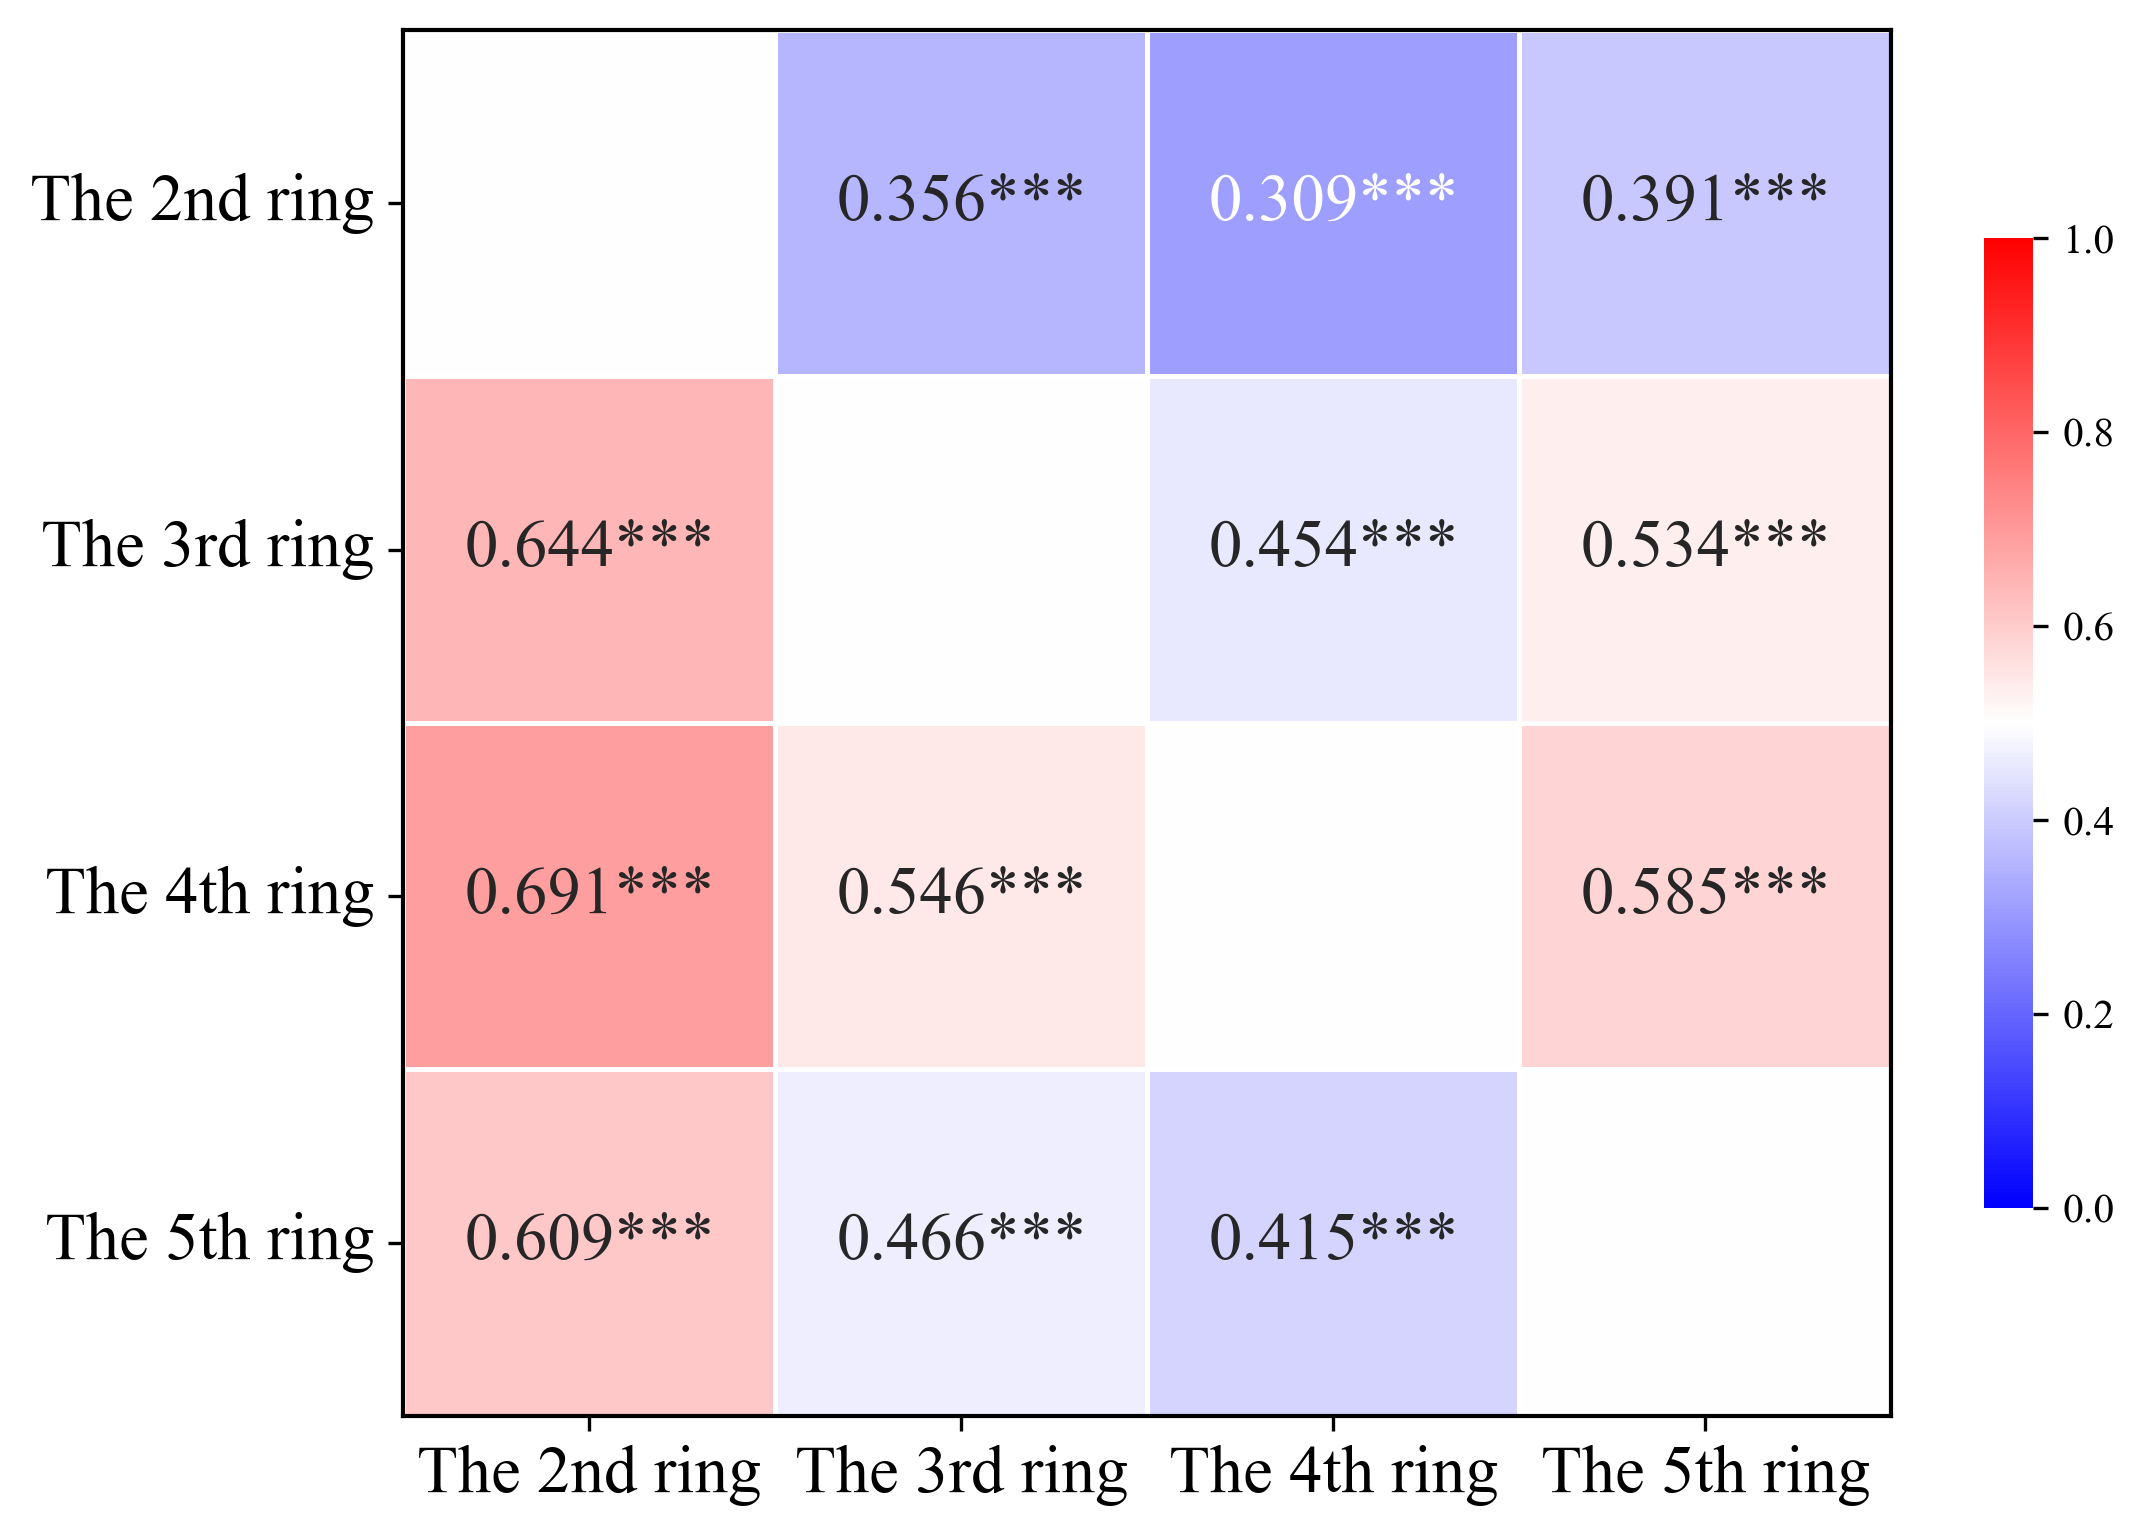

In [13]:
ax = KandD(data=data_a, label='HSV')

Groups: ['The 2nd ring' 'The 3rd ring' 'The 4th ring' 'The 5th ring']
Sample sizes: [16979, 21313, 24529, 22754]

Kruskal–Wallis H test:
H statistic = 6475.4794, p-value = 0.000000
[['' '0.670***' '0.728***' '0.656***']
 ['0.330***' '' '0.578***' '0.516***']
 ['0.272***' '0.422***' '' '0.447***']
 ['0.344***' '0.484***' '0.553***' '']]


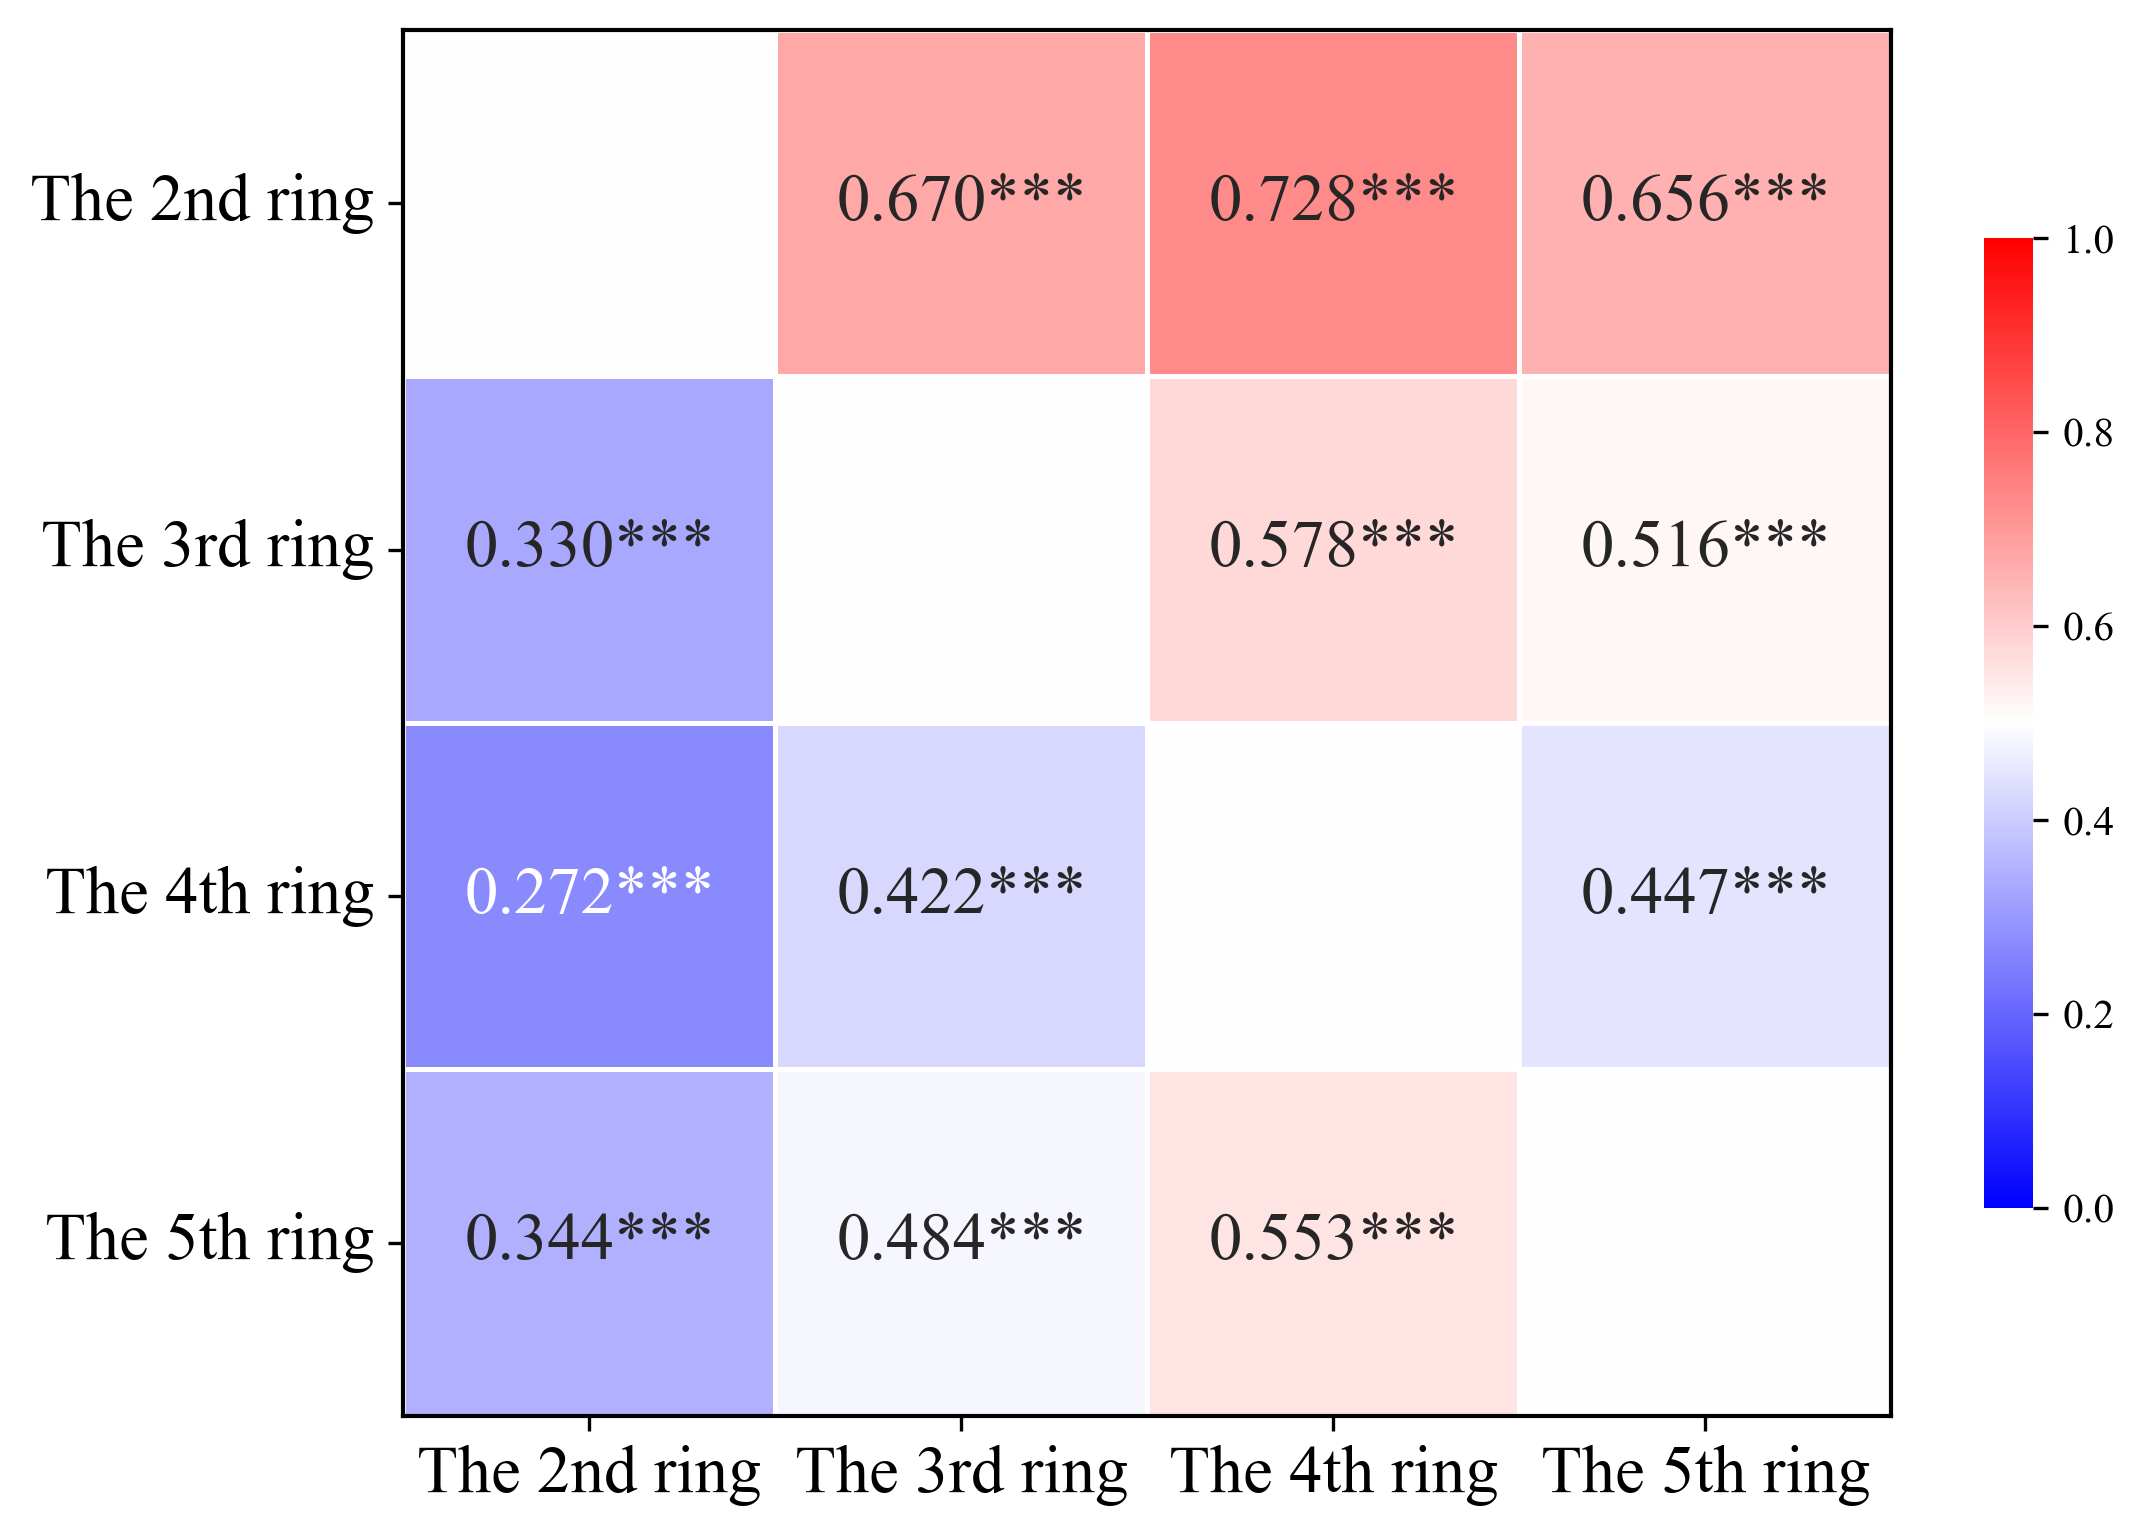

In [14]:
ax = KandD(data=data_a, label='SHSR')

Groups: ['The 2nd ring' 'The 3rd ring' 'The 4th ring' 'The 5th ring']
Sample sizes: [16979, 21313, 24529, 22754]

Kruskal–Wallis H test:
H statistic = 1157.6586, p-value = 0.000000
[['' '0.528***' '0.582***' '0.576***']
 ['0.472***' '' '0.557***' '0.550***']
 ['0.418***' '0.443***' '' '0.495*']
 ['0.424***' '0.450***' '0.505*' '']]


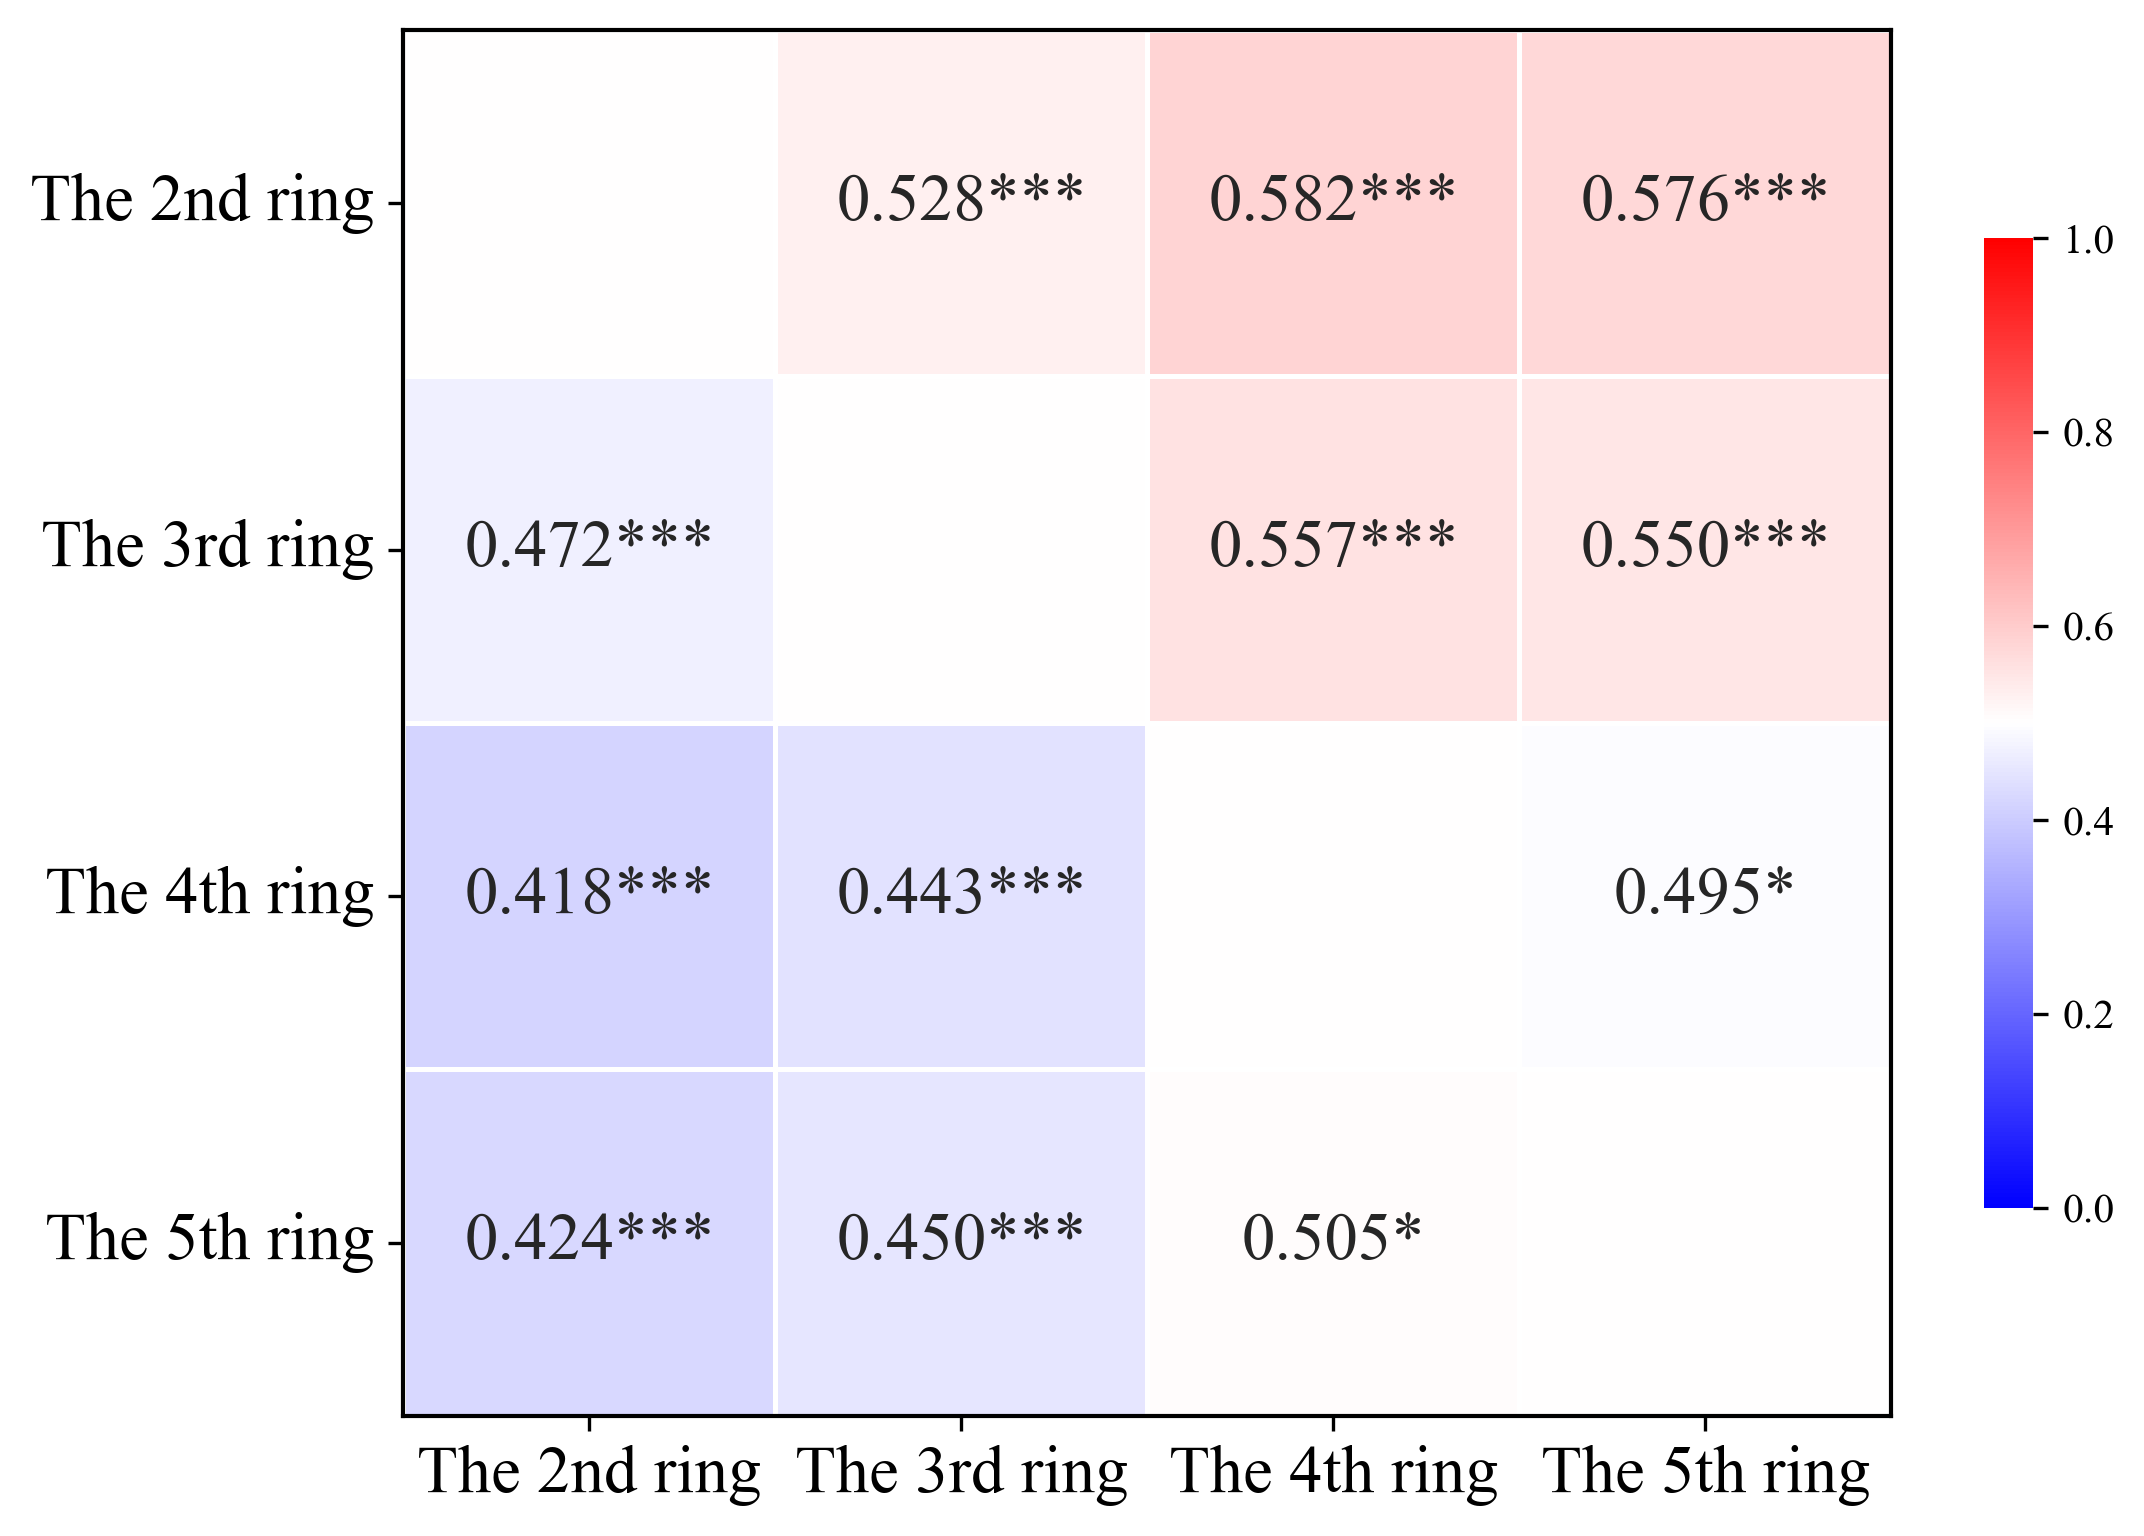

In [15]:
ax = KandD(data=data_a, label='MCHSD')

Groups: ['The 2nd ring' 'The 3rd ring' 'The 4th ring' 'The 5th ring']
Sample sizes: [16979, 21313, 24529, 22754]

Kruskal–Wallis H test:
H statistic = 1865.5742, p-value = 0.000000
[['' '0.436***' '0.503' '0.565***']
 ['0.564***' '' '0.558***' '0.617***']
 ['0.497' '0.442***' '' '0.556***']
 ['0.435***' '0.383***' '0.444***' '']]


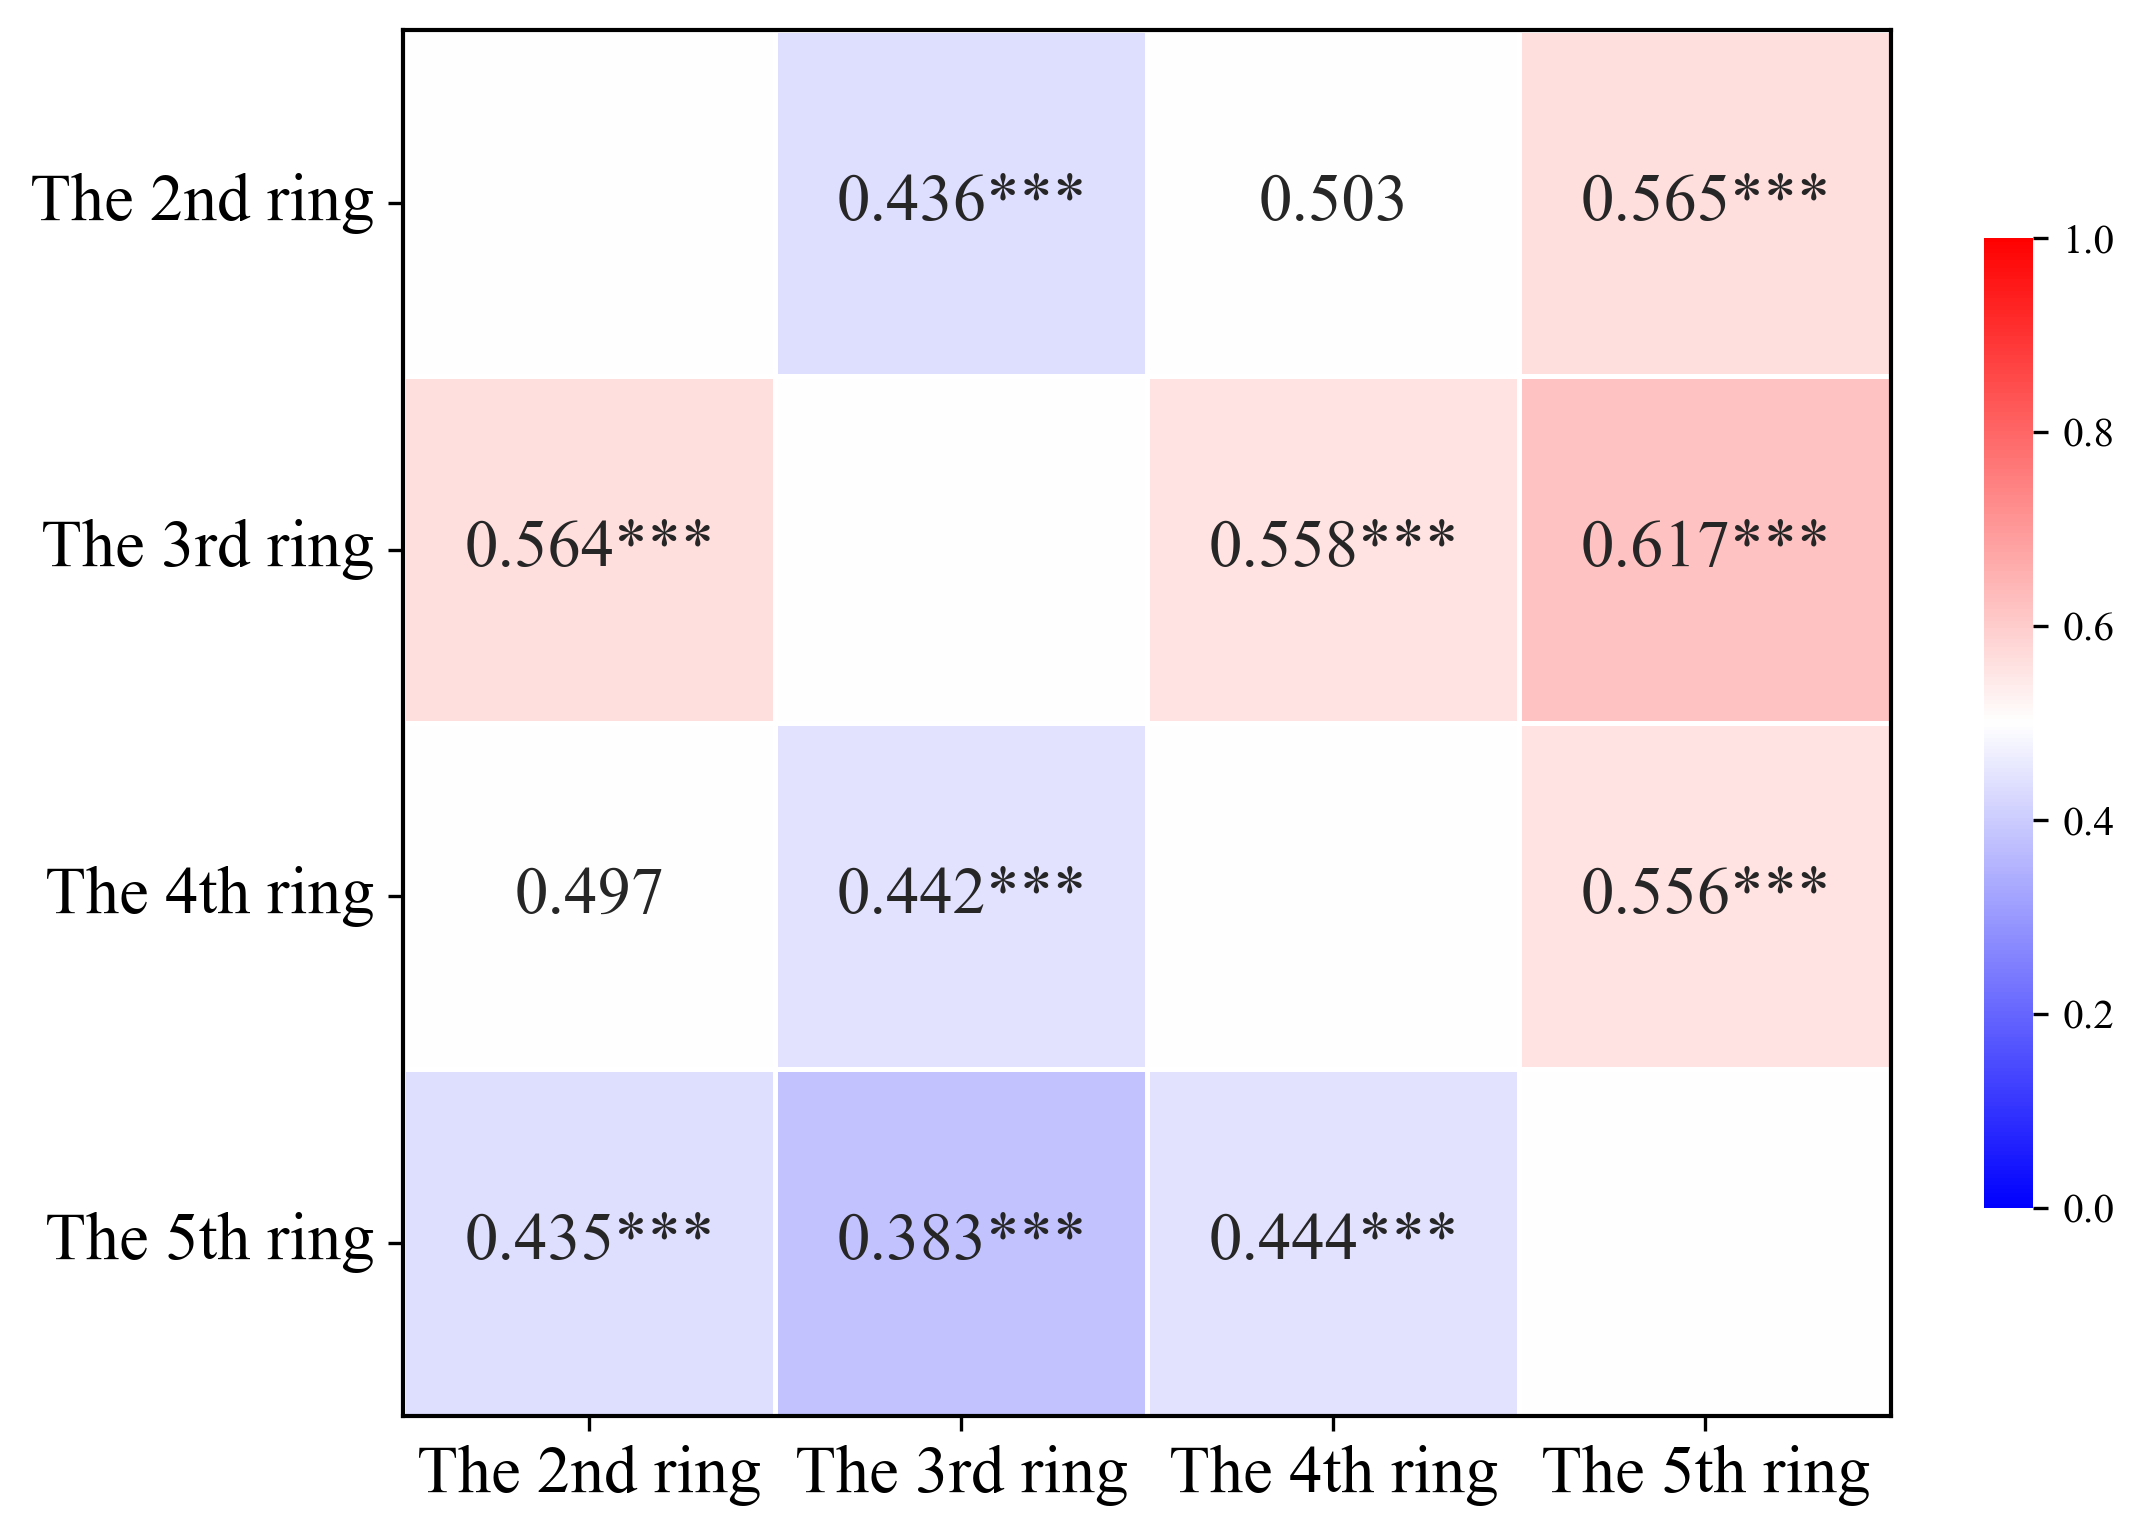

In [16]:
ax = KandD(data=data_a, label='CEHL')